# ESM tutorial

This tutorial gives how to use the effective screening medium (ESM) method implemented in QUANTUM ESPRESSO distribution. 
This tutorial is consisted as following two-parts.  

* Example 1: Water molecule  
    First, we learn the fundamental option via the calculation of isolated molecule. 

* Example 2: Al(111) surface  
    Next, we learn the application of ESM method for material surface.  
    
Throughout the tutorial, we use Atomic Simulation Enviroment (ASE: https://wiki.fysik.dtu.dk/ase/), which is python liblary for setting up, manipulating, running, visualizing and analyzing atomistic simulations and plane-wave basis sets within pseudopotential framework code QUANTUM ESPRESSO distribution (https://www.quantum-espresso.org).   
First of all, we should download the ASE package of Minoru Otani version from his GitLab (https://gitlab.com/minoru-otani/ase) and QUANTUM ESPRESSO distribution (QE) from https://www.quantum-espresso.org. 
After downloading, you should install the ASE and QE.  
If you have the claster machine or super computer account accessing to them with the SSH,  
QE should be compiled on the remotehosts.  

### NOTE
* Installation guide of ASE package can be found at ASE web site (https://wiki.fysik.dtu.dk/ase/install.html).  
* PWscf and PP codes are needed to try this tutorial.

After installation, run following two python scripts on Jupyter notebook: 

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

In [4]:
import os
import time
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from ase import Atoms
from ase.io import read, write
from ase.io.cube import read_cube_data
from ase.visualize import view
from ase.io.espresso import read_espresso_extra
from pyscript.remotejob import RemoteJob
from pyscript import  plottools as pt

Now, we finish the preparation for starting of the tutorials. 
In the next section, we start the Example 1. 

# Example 1: Water molecule

Here, we will execute the two calculations:  
* Water molecule under the periodic boundary condition (PBC)  
* Water molecule using ESM method  



## Water molecule (periodic boundary condition)

Here, we recall the drowback of the PBC calculation for polar-molecule and learn how to use this tutorial.  
First, we calculate H$_2$O molecule using usual DFT calculation under the PBC.  

### Determination of project and job infomation
Run the following two python scripts on your Jupyter-notebook. 

In [5]:
project = 'H2O_pbc'
prj_info = {
    'project': project,
    'homedir': os.path.expanduser('~')+'/program',
    'prefixes':  ['H2O'],
}

In [6]:
job_info = {
    'node':     1,   
    'mpinum':   28,  
    'ompnum':   1,
    'cputime':  dt.timedelta(days=0, hours=0, minutes=30),
    'para_img': 1,
    'para_kpt': 1,
    'para_tsk': 1,
    'para_bnd': 1,
}

The first script determines the project name, position of home directry (local host), and prefix of files,  
which corresponds to the `prefix` of PWscf inputs, respectively.  
The second script determines job-running information.  
* `node`: request computational nodes
* `mpinum`: the number of mpi procs.
* `ompnum`: the number of omp threads.
* `cputime`: corresponding to the `max_seconds` value of PWscf inputs. 
* `para_*`: respectively corresponding to number of divisions for MPI parallel running of PWscf. 

After runnning above scripts, `program` directry is created below the `/Users/username/`.  
The results of this tutorial is summarized in the program directry. 

### Set the remote job infomation and connect to Remotehost 

First, you edit `remotehosts.json` file as suite for your job-running conditions on the target remote-host.  
Details of `remotehosts.json` can be found in the header of `pyscript/remotefiles.py`.  
After editing `remotehosts.json`, the file is set below the `Users/username/program/` directry.  

* Hints for editing json file  
It is note that, in the stage of remote-job running, job script is automatically generated by `pyscript/remotejob.py`  
using input values of `remotehosts.json`, `prj_info` and `job_info`.  
Furthermore, values `QUEUE`, `TOTPROC`, `COPY_BASE_DIR`, `BINDIR/PROG`, `KPT`, `BND` and `TSK`  
in the json file should not be changed, because these values are targets of replace command in python code. 

Next, run the following python script to connect to the requested Remotehost.  

`NOTE`: You should check the `remote` value  in the following script as same as  
the key value of your json file. If not, you edit the `remote` value. 


In [7]:
rjob = RemoteJob(prj_info, job_info, remote='enemat')
rjob.connecthost()

Local working directory (/Users/hagiwara/program/H2O_pbc) exists.
File list: H2O.inp  H2O.out  H2O_pp.inp  job_submit  H2O.cube  H2O_pp.out  sub_H2O.sh  currentjob.txt
Passphrase:········
Password:········
Remote working directory (/home/otani/hagiwara/tuto/H2O_pbc) exists.
File list: fort.894  H2O.cube  H2O.inp  H2O.out  H2O_pp.inp  H2O_pp.out  H2O_pp.tmp  job_submit  out  sub_H2O.sh  tmp


### Make input file for PWscf using ASE

Thanks to the ASE package, after runnig the following python script, input files for the PWscf is autmatically generated. 

In [9]:
prefix = 'H2O_pbc'
atoms = Atoms('OH2', [(5.00000000, 5.0000000000, 5.00000000),
                      (5.75754080, 5.0000000000, 5.58707964),
                      (4.24245910, 5.0000000000, 5.58707964)], 
             cell=[(10.0000000000,  0.0000000000,  0.0000000000),
                   ( 0.0000000000, 10.0000000000,  0.0000000000),
                   ( 0.0000000000,  0.0000000000, 10.0000000000)],
              PBC=(True, True, True)
)
pseudo={'H':'H.pbe-van_ak.UPF', 'O':'O.pbe-van_ak.UPF'}

input_data = {
    'control': {
        'calculation'        : 'scf',
        'restart_mode'       : 'from_scratch',
        'prefix'             : 'prefix',
        'max_seconds'        : rjob.maxseconds,
        'pseudo_dir'         : rjob.pseudo,
        'outdir'             : rjob.workdir+'/tmp',
        'tprnfor'            : True,
    },
    'system': {
        'ecutwfc'            : 25.0, 
        'ecutrho'            : 200.0,
        'occupations'        : 'fixed', 
        'nbnd'               : 20,
    },
    'electrons': {
        'mixing_beta'        : 0.5,
    }
}

input_data_chng = {
    rjob.prefixes[0]: {
        'control': {
            'prefix'     : rjob.prefixes[0],
        }
    }
}

for prefix in rjob.prefixes:
    for group in input_data_chng[prefix]:
        for name, value in input_data_chng[prefix][group].items():
            input_data[group][name] = value
            write(rjob.srcinp[prefix], atoms, format='espresso-in', input_data=input_data, 
                  pseudopotentials=pseudo)

### View unit cell 

Following script desplay the atomic structure in your unit cell.  
Please, check the unit cell after running the scripyt.

In [1]:
view(atoms, viewer='ngl')

NameError: name 'view' is not defined

### Submit your job to the remotehost

Previous steps prepare your remote-job.  
Next scpript generates your input and job script files and send them to the remotehost using `$ scp` command.  
After sending input files, your job is submitted to the remotehost.  
The status of your job on the remotehost is desplayed below.

In [11]:
rjob.submit_files(prog='pw.x', inpf=rjob.destinp, outf=rjob.destout)

putfiles = [
    rjob.srcsub,
]
putfiles.extend([file for file in rjob.srcinp.values()])
putfiles.extend([file for file in rjob.srcshell.values()])
print('Send files...')
rjob.put_file(putfiles)
for i in range(len(putfiles)):
    print("{0} --> {1}".format(putfiles[i], rjob.workdir))
    
# Submission of JOB
rjob.submit_job()

# USE qstat command for checking job status
rjob.remote_qstat()

Send files...
/Users/hagiwara/program/H2O_pbc/job_submit --> /home/otani/hagiwara/tuto/H2O_pbc
/Users/hagiwara/program/H2O_pbc/H2O.inp --> /home/otani/hagiwara/tuto/H2O_pbc
/Users/hagiwara/program/H2O_pbc/sub_H2O.sh --> /home/otani/hagiwara/tuto/H2O_pbc
['job']
Submit a job (H2O), Job ID = job
job-ID  prior   name       user         state submit/start at     queue                          slots ja-task-ID 
-----------------------------------------------------------------------------------------------------------------
  11454 0.00000 H2O        otani        qw    09/18/2019 10:26:45                                   28        


If you want to check your job status on the remotehost,  
please execute following script.  
When your job is not finished, job status is displayed below. 

In [17]:
rjob.remote_qstat()

### Copy the results of SCF calculation to the localhost

Here, copy the BASE calculation result (typically charge netural calculation) to BASE directory for later use.  
Then, calculation results are sent from the remotehost to localhost (`Users/username/program/H2O_pbc`). 

In [18]:
source_dir = rjob.workdir+'/tmp/'+rjob.prefixes[0]+'.save'
rjob.set_base(source_dir, rjob.baseesm)  

getfiles = []
getfiles.extend([file for file in rjob.destout.values()])
print('Get files...')
rjob.get_file(getfiles)
for i in range(len(getfiles)):
    print("{0} --> {1}".format(getfiles[i], rjob.prjhome))

BASE directory exists -> Remove & Copy /home/otani/hagiwara/tuto/H2O_pbc/tmp/BASE.ESM
Get files...
/home/otani/hagiwara/tuto/H2O_pbc/H2O.out --> /Users/hagiwara/program/H2O_pbc


### Print out the results of SCF calculation written in `H2O.out`

Here, we print out Total energy, forces and total number of charge described in `H2O.out`. 

In [19]:
# Set input and output data
scf_result = {}
extra_result = {}
for prefix in rjob.prefixes:
    scf_result[prefix] = read(rjob.srcout[prefix], index=':', format='espresso-out')
    with open(rjob.srcout[prefix], mode='rt') as fd:
        extra_result[prefix] = read_espresso_extra(fd, index=':')
        
# Print total energy and forces from H2O.out
for prefix in rjob.prefixes:
    for image in scf_result[prefix]:
#        calc = image.get_calculator()
#        print(calc.get_fermi_level())
        print('-----------------------------------')
        print('Total energy (eV)  '+str(image.get_total_energy()))
        print('-----------------------------------')
        print('Forces acting on atoms (eV/angst.)')
        print('-----------------------------------')
        print(image.get_forces())
        
# Print the number of total charge from input data
for prefix in rjob.prefixes:
    extra = extra_result[prefix]
    print('-----------------------------------')
    print("tot_charge ", f"{extra[-1]['tot_charge']:>12.5}")
    print('-----------------------------------')


-----------------------------------
Total energy (eV)  -468.43871627844715
-----------------------------------
Forces acting on atoms (eV/angst.)
-----------------------------------
[[ 0.          0.         -0.95695817]
 [ 0.70458742  0.          0.47847921]
 [-0.70458742  0.          0.47847921]]
-----------------------------------
tot_charge           0.0
-----------------------------------


### Execute post proceeding script (`pp.x`) 

To visualize xy-averaged electrostatic potential, we execute `pp.x` on the remotehost.  
This procedure generates electrostatic potential with gaussian cube file format. 

In [20]:
# Make input for pp.x as H2O_pp.in
for prefix in rjob.prefixes:
    f=open(rjob.srcpp_inp[prefix], mode='w')
    f.write("&inputpp\n")
    f.write("   prefix='"+prefix+"',\n")
    f.write("   outdir='"+rjob.outdir+"',\n")
    f.write("   filplot='"+rjob.destpp_tmp[prefix]+"',\n")
    f.write("   plot_num=11,\n")
    f.write("/\n")
    f.write("&plot\n")
    f.write("   nfile=1,\n")
    f.write("   iflag=3,\n")
    f.write("   output_format=6,\n")
    f.write("   fileout='"+rjob.destcube[prefix]+"',\n")
    f.write("/\n")
    f.close()

# Generate job submit files
rjob.submit_files(prog='pp.x', inpf=rjob.destpp_inp, outf=rjob.destpp_out)

putfiles = [
    rjob.srcsub,
]
putfiles.extend([file for file in rjob.srcpp_inp.values()])
putfiles.extend([file for file in rjob.srcshell.values()])
print('Send files...')
rjob.put_file(putfiles)
for i in range(len(putfiles)):
    print("{0} --> {1}".format(putfiles[i], rjob.workdir))
    
# Job submittion
rjob.submit_job()

#Qstat
rjob.remote_qstat()

Send files...
/Users/hagiwara/program/H2O_pbc/job_submit --> /home/otani/hagiwara/tuto/H2O_pbc
/Users/hagiwara/program/H2O_pbc/H2O_pp.inp --> /home/otani/hagiwara/tuto/H2O_pbc
/Users/hagiwara/program/H2O_pbc/sub_H2O.sh --> /home/otani/hagiwara/tuto/H2O_pbc
['job']
Submit a job (H2O), Job ID = job
job-ID  prior   name       user         state submit/start at     queue                          slots ja-task-ID 
-----------------------------------------------------------------------------------------------------------------
  11455 0.00000 H2O        otani        qw    09/18/2019 10:27:19                                   28        


In [24]:
rjob.remote_qstat()

In [25]:
getfiles = []
getfiles.extend([file for file in rjob.destpp_out.values()])
getfiles.extend([file for file in rjob.destcube.values()])
print('Get files...')
rjob.get_file(getfiles)
for i in range(len(getfiles)):
    print("{0} --> {1}".format(getfiles[i], rjob.prjhome))

Get files...
/home/otani/hagiwara/tuto/H2O_pbc/H2O_pp.out --> /Users/hagiwara/program/H2O_pbc
/home/otani/hagiwara/tuto/H2O_pbc/H2O.cube --> /Users/hagiwara/program/H2O_pbc


### xy-planar averaged electrostatic potential

Here, we can visualize the result of xy-planar averaged electrostatic potential of a water molecule using python script.  
As clearly seen, the flat potential region is not appeared, because dipole interaction between image cells is caused.  
To avoid image cell interaction, several methods have been developped.  

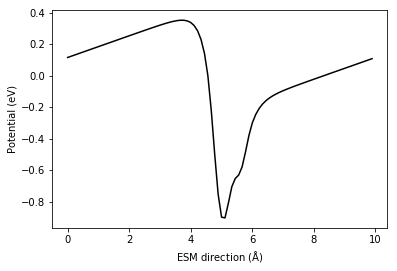

In [26]:
data, atoms = read_cube_data(rjob.srccube['H2O'])
NX, NY, NZ = data.shape[0], data.shape[1], data.shape[2]
output_pot = np.array([[nz*atoms.cell[2][2]/NZ,np.sum(data[:,:,nz])/(NX*NY)] for nz in range(NZ)])

plt.xlabel(r'ESM direction ($\mathrm{\AA}$)')
plt.ylabel('Potential (eV)')
plt.plot(output_pot[:,0],output_pot[:,1]*13.6,color='black',linestyle='solid')
plt.show()

## Water molecule ('bc1' boundary condition)

Here, we learn how to use the ESM calculation with the "Vacuum/Cell/Vacuum" boundary condistion.  
We find the new two inputs from following python scripts:

* `assume_isolated`  
* `esm_bc`  

First of all, check the meanings of these input values at the Web site of input file discription for PWscf code.  
The boundary condition of Vacuum/Cell/Vacuum indicates that the z-direction of the unit-cell is sandwiched by infinite vacuums.  
Thus, we treat unitcell is the mix boundary condition:  
* xy-plane is treaeted under the PBC.  
* z-direcion is treated as the open-boundary.  

The theoretical back-ground of ESM technique can be found in elsewhere (M. Otani and O. Sugino, PRB 73, 115407 (2006).).  
Then, run the following python scripts.

In [357]:
prefix = 'H2O_bc1'
atoms = Atoms('OH2', [(5.00000000, 5.0000000000, 0.00000000),
                      (5.75754080, 5.0000000000, 0.58707964),
                      (4.24245910, 5.0000000000, 0.58707964)], 
             cell=[(10.0000000000,  0.0000000000,  0.0000000000),
                   ( 0.0000000000, 10.0000000000,  0.0000000000),
                   ( 0.0000000000,  0.0000000000, 10.0000000000)],
)
pseudo={'H':'H.pbe-van_ak.UPF', 'O':'O.pbe-van_ak.UPF'}

input_data = {
    'control': {
        'calculation'        : 'scf',
        'restart_mode'       : 'from_scratch',
        'prefix'             : 'prefix',
        'max_seconds'        : rjob.maxseconds,
        'pseudo_dir'         : rjob.pseudo,
        'outdir'             : rjob.workdir+'/tmp',
         'tprnfor'            : True,
    },
    'system': {
        'ecutwfc'            : 25.0, 
        'ecutrho'            : 200.0,
        'occupations'        : 'fixed', 
        'nbnd'               : 20,
        'assume_isolated'    : 'esm',
        'esm_bc'             : 'bc1',
    },
    'electrons': {
        'mixing_beta'        : 0.5,
    }
}

input_data_chng = {
    rjob.prefixes[0]: {
        'control': {
            'prefix'     : rjob.prefixes[0],
        }
    }
}

for prefix in rjob.prefixes:
    for group in input_data_chng[prefix]:
        for name, value in input_data_chng[prefix][group].items():
            input_data[group][name] = value
            write(rjob.srcinp[prefix], atoms, format='espresso-in', input_data=input_data, 
                  pseudopotentials=pseudo)

In [358]:
rjob.submit_files(prog='pw.x', inpf=rjob.destinp, outf=rjob.destout)

putfiles = [
    rjob.srcsub,
]
putfiles.extend([file for file in rjob.srcinp.values()])
putfiles.extend([file for file in rjob.srcshell.values()])
print('Send files...')
rjob.put_file(putfiles)
for i in range(len(putfiles)):
    print("{0} --> {1}".format(putfiles[i], rjob.workdir))

['#!/bin/bash/sh\n', '#$ -cwd\n', '#$ -pe qall 28\n', '#$ -N H2O\n', '#$ -o out\n', '#$ -e err\n', '#$ -j y\n', 'export OMP_NUM_THREADS=1\n', 'COPY_BASE_DIR', 'mpirun -np 28 /home/otani/hagiwara/q-e-esm-rism61/bin/PROG -nk 1 -nb 1 -nt 1 < INPF > OUTF\n']
None
Send files...
/Users/hagiwara/program/H2O_pbc/job_submit --> /home/otani/hagiwara/tuto/H2O_pbc
/Users/hagiwara/program/H2O_pbc/H2O.inp --> /home/otani/hagiwara/tuto/H2O_pbc
/Users/hagiwara/program/H2O_pbc/sub_H2O.sh --> /home/otani/hagiwara/tuto/H2O_pbc


In [359]:
rjob.submit_job()

['job']
Submit a job (H2O), Job ID = job


In [364]:
rjob.remote_qstat()

In [365]:
getfiles = []
getfiles.extend([file for file in rjob.destout.values()])
getfiles.extend([file for file in rjob.destesm1.values()])
print('Get files...')
rjob.get_file(getfiles)
for i in range(len(getfiles)):
    print("{0} --> {1}".format(getfiles[i], rjob.prjhome))

Get files...
/home/otani/hagiwara/tuto/H2O_pbc/H2O.out --> /Users/hagiwara/program/H2O_pbc
/home/otani/hagiwara/tuto/H2O_pbc/tmp/H2O.esm1 --> /Users/hagiwara/program/H2O_pbc


In [366]:
scf_result = {}
extra_result = {}
for prefix in rjob.prefixes:
    scf_result[prefix] = read(rjob.srcout[prefix], index=':', format='espresso-out')
    with open(rjob.srcout[prefix], mode='rt') as fd:
        extra_result[prefix] = read_espresso_extra(fd, index=':')

In [367]:
for prefix in rjob.prefixes:
    for image in scf_result[prefix]:
#        calc = image.get_calculator()
#        print(calc.get_fermi_level())
        print(image.get_total_energy())
        print(image.get_forces())

-468.4253122228688
[[ 0.          0.         -0.93014696]
 [ 0.71328675  0.          0.46840409]
 [-0.71328675  0.          0.46840409]]


In [368]:
for prefix in rjob.prefixes:
    extra = extra_result[prefix]
    print('***** Total charge from input file *****')
    print("tot_charge = ", f"{extra[-1]['tot_charge']:>12.5}")
    if extra[-1]['trism'] is True:
        print('***** Chemical potential of solvation from 1D-RISM *****')
        print('                          Closure      Gauss Fluctuation')
        for solvx in extra[-1]['mols']:
            for idy, solvy in enumerate(extra[-1]['mols']):
                if idy == 0:
                    print(f"{solvx:^10}{solvy:^10}{extra[-1]['1d_chem_pot'][solvx][solvy][0]:>16.6f}"
                          f"{extra[-1]['1d_chem_pot'][solvx][solvy][1]:>16.6f}")
                else:
                    print(f"          {solvy:^10}{extra[-1]['1d_chem_pot'][solvx][solvy][0]:>16.6f}"
                          f"{extra[-1]['1d_chem_pot'][solvx][solvy][1]:>16.6f}")
        print('***** Solvent information from 3D/Laue-RISM *****')
        print("Image  solvent    # of solv.    Solv. chg(e).   Chem. pot. (kcal/mol)")
        for idx, image in enumerate(extra[0:-1]):
            for idy, solv in enumerate(extra[-1]['mols']):
                print(f"{idx+1:^5}{solv:^10}{image['solvent_num'][idy]:>12.6f}{image['solvent_chg'][idy]:>16.6f}"
                      f"{image['solvent_pot'][idy]:18.6f}")
    if extra[-1]['lfcp'] is True:
        print('***** FCP information *****')
        for image in extra[0:-1]:
            print("Total charge", f"{image['fcp_current_chg']:12.5f}"," --(next)-->", f"{image['fcp_next_chg']:>12.5f}")
            print("Fermi energy", f"{image['fcp_fermi']:12.5f}", "(eV)")
            print("Force on FCP", f"{image['fcp_force']:12.5f}", "(eV)")

***** Total charge from input file *****
tot_charge =           0.0


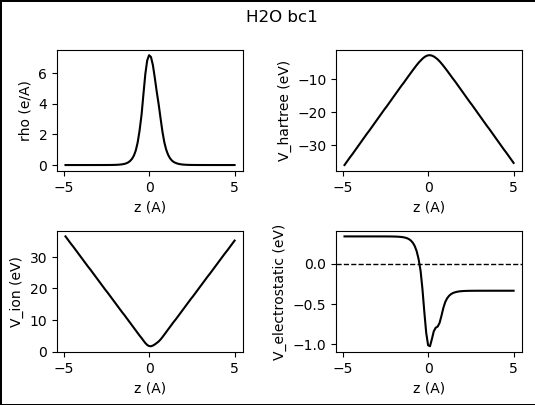

In [269]:
pt.plot_esm1(rjob.prjhome+'/'+rjob.prefixes[0]+'.esm1',titlename='H2O bc1')

Here, we obtain the results of rho, V_hartree, V_ion and V_electrostatic with ESM correction.  
Thanks to "Vacuum/Slab/Vacuum" condition, interaction between image cells is cancelled out and flat vacuum level can be found in V_electrostatic.  
In addition, energy level zero under the OBC is defined as midpoint between $V(z=-\infty)$ and $V(z=+\infty)$, where $V(z)$ is the electrostatic potential. 


In [27]:
#v = nv.show_ase(atoms)
#v.add_ball_and_stick()
#v.add_unitcell()
#v
temp = atoms
print(atoms.get_cell())
temp.translate((0,0,-(np.sum(temp.positions[:,2]))/temp.positions.shape[0]))
view(atoms, viewer='ngl')

Cell([10.000020501188075, 10.000020501188075, 10.000020501188075], pbc=False)


# Example 2: Al(111) surface

Here, we learn how to use the ESM calculation for the surface.  
As for example, we use Al(111) surface using repeated slab model having four atomic layers.  

Hereafter, we will use following three types of ESM boundary conditions:  

* `bc1`: Vacuum/Slab/Vacuum (VSV)
* `bc2`: Metal/Slab/Metal (MSM)  
* `bc3`: Vacuum/Slab/Metal (VSM)



## Al(111) surface ('bc1' boundary condition)

First, we use the VSV model. The VSV model is already used in the previous exampe.  This model is useful for ordinal slab calculation with thin vacuum layer, because, in this model, z-direction of surface slab, which corresponds to the surface normal-direction, is treated as open boundary condition (OBC). 

Run following scripts, and calculate electronic structure of Al(111) surface with VSV model. 

In [523]:
project = 'Al-slab'
prj_info = {
    'project': project,
    'homedir': os.path.expanduser('~')+'/Program',
    'prefixes':  ['Al0'],
}

### k-point parallization

Since the k-point sampling is required for the slab calculation, we use k-point parallization mode hereafter.  
Following a set of `job_info` is a sample for using k-parallel running of PWscf.  

In [524]:
job_info = {
    'node':     4,   
    'mpinum':   28,  
    'ompnum':   1,
    'cputime':  dt.timedelta(days=0, hours=0, minutes=30),
    'para_img': 1,
    'para_kpt': 4,
    'para_tsk': 1,
    'para_bnd': 1,
}

In [525]:
rjob = RemoteJob(prj_info, job_info, remote='enemat')

Local working directory (/Users/hagiwara/Program/Al-slab) exists.
File list: Alp1.out  Al0.esm1  Alp2.out  Al_E.out  Alm1.esm1  Al111_bc3_vp015.esm1  sub_Al0.sh  Al_E.inp  Alp2.inp  donejob.txt  Alp1.inp  Alp1.esm1  Al111_bc3_m001.esm1  Al111_bc3_vp015.inp  sub_Alm1.sh  Al111_bc3_m001.out  Al111_bc3_m001.inp  Al111_bc3_vp015.out  job_submit  sub_Alp2.sh  Al_E.esm1  Alm1.out  sub_Alp1.sh  sub_Al111_bc3_vp015.sh  Alm2.out  sub_Al111_bc3_m001.sh  Alm2.inp  Alm1.inp  sub_Alm2.sh  Alp2.esm1  Al0.out  sub_Al_E.sh  Al0.inp  currentjob.txt  Alm2.esm1
Passphrase:········
Password:········


In [526]:
rjob.connecthost()

Remote working directory (/home/otani/hagiwara/tuto/Al-slab) exists.
File list: Al0.inp  Al0.out  Al111_bc3_m001.inp  Al111_bc3_m001.out  Al111_bc3_vp015.inp  Al111_bc3_vp015.out  Al_E.inp  Al_E.out  Alm1.inp  Alm1.out  Alm2.inp  Alm2.out  Alp1.inp  Alp1.out  Alp2.inp  Alp2.out  job_submit  out  sub_Al0.sh  sub_Al111_bc3_m001.sh  sub_Al111_bc3_vp015.sh  sub_Al_E.sh  sub_Alm1.sh  sub_Alm2.sh  sub_Alp1.sh  sub_Alp2.sh  tmp


In [527]:
atoms = Atoms('Al4', [(2.85595455,  0.00000000,  3.49781569),
                      (1.42797727,  0.82444307,  1.16593856),
                      (2.85595454,  1.64888613, -1.16593856),
                      (0.00000000,  0.00000000, -3.49781569)], 
             cell=[( 2.85595455,  0.0000000000,  0.0000000000),
                   ( 1.42797727,  2.4733291965,  0.0000000000),
                   ( 0.00000000,  0.0000000000, 22.9956313827)],
              pbc=(True, True, False)
)
pseudo={'Al':'Al.pbe-n-van.UPF'}

input_data = {
    'control': {
        'calculation'        : 'scf',
        'restart_mode'       : 'from_scratch',
        'prefix'             : 'prefix',
        'max_seconds'        : rjob.maxseconds,
        'pseudo_dir'         : rjob.pseudo,
        'outdir'             : rjob.workdir+'/tmp',
        'tprnfor'            : True,
    },
    'system': {
        'ecutwfc'            : 20.0, 
        'ecutrho'            : 200.0,
        'occupations'        : 'smearing',
        'smearing'           : 'mp',
        'degauss'            : 0.03,
        'nosym'              : True,
        'assume_isolated'    : 'esm',
        'esm_bc'             : 'bc1',
    },
    'electrons': {
        'mixing_beta'        : 0.3,
    }
}
input_data_chng = {
    rjob.prefixes[0]: {
        'control': {
            'prefix'     : rjob.prefixes[0],
        },
    },
}

for prefix in rjob.prefixes:
    for group in input_data_chng[prefix]:
        for name, value in input_data_chng[prefix][group].items():
            input_data[group][name] = value
            write(rjob.srcinp[prefix], atoms, format='espresso-in', input_data=input_data, 
                  pseudopotentials=pseudo, kpts=(8, 8, 1), koffset=(1, 1, 0))

In [528]:
#v = nv.show_ase(atoms)
#v.add_ball_and_stick()
#v.add_unitcell()
#v
view(atoms, viewer='ngl')

In [529]:
rjob.submit_files(prog='pw.x', inpf=rjob.destinp, outf=rjob.destout)

putfiles = [
    rjob.srcsub,
]
putfiles.extend([file for file in rjob.srcinp.values()])
putfiles.extend([file for file in rjob.srcshell.values()])
print('Send files...')
rjob.put_file(putfiles)
for i in range(len(putfiles)):
    print(f"{putfiles[i]} --> {rjob.workdir}")

['#!/bin/bash/sh\n', '#$ -cwd\n', '#$ -pe qall 112\n', '#$ -N H2O\n', '#$ -o out\n', '#$ -e err\n', '#$ -j y\n', 'export OMP_NUM_THREADS=1\n', 'COPY_BASE_DIR', 'mpirun -np 28 /home/otani/hagiwara/q-e-esm-rism61/bin/PROG -nk 4 -nb 1 -nt 1 < INPF > OUTF\n']
None
Send files...
/Users/hagiwara/Program/Al-slab/job_submit --> /home/otani/hagiwara/tuto/Al-slab
/Users/hagiwara/Program/Al-slab/Al0.inp --> /home/otani/hagiwara/tuto/Al-slab
/Users/hagiwara/Program/Al-slab/sub_Al0.sh --> /home/otani/hagiwara/tuto/Al-slab


In [530]:
rjob.submit_job()

['job']
Submit a job (Al0), Job ID = job


In [535]:
rjob.remote_qstat()

In [536]:
getfiles = []
getfiles.extend([file for file in rjob.destout.values()])
getfiles.extend([file for file in rjob.destesm1.values()])
print('Get files...')
rjob.get_file(getfiles)
for i in range(len(getfiles)):
    print("{0} --> {1}".format(getfiles[i], rjob.prjhome))

Get files...
/home/otani/hagiwara/tuto/Al-slab/Al0.out --> /Users/hagiwara/Program/Al-slab
/home/otani/hagiwara/tuto/Al-slab/tmp/Al0.esm1 --> /Users/hagiwara/Program/Al-slab


### Plot `prefix.esm1` file

Now we plot laterally averaged electron density, Hartree, ionic and electrostatic potentials described in  the `prefix.esm1` file that is located under your output directry. 

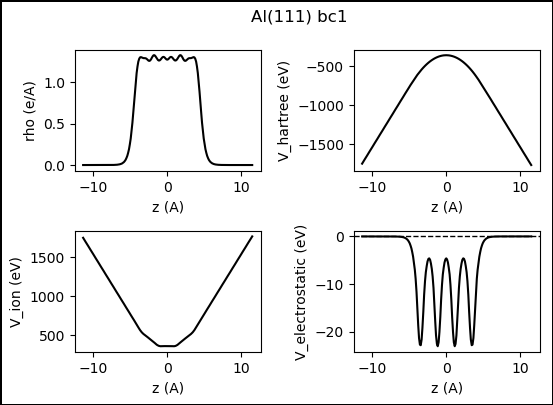

In [537]:
pt.plot_esm1(rjob.prjhome+'/'+rjob.prefixes[0]+'.esm1',titlename='Al(111) bc1')

### Work function

Forfurther analysys, we calculate the work function at the Al(111). 
Thanks to Janack's theorem, the work function $\Phi$ can be defined as difference between the vacuum ($E_{\rm vac}$) and Fermi levels ($E_{\rm F}$).  

$$
\Phi = E_{\rm vac} - E_{\rm F}
$$

By using following script, you can extract the $E_{\rm F}$ from the output file of PWscf.  
Try to calculate workfunction using above formula.  

In [538]:
scf_result = {}
extra_result = {}
for prefix in rjob.prefixes:
    scf_result[prefix] = read(rjob.srcout[prefix], index=':', format='espresso-out')
    with open(rjob.srcout[prefix], mode='rt') as fd:
        extra_result[prefix] = read_espresso_extra(fd, index=':')

In [539]:
for prefix in rjob.prefixes:
    for image in scf_result[prefix]:
        calc = image.get_calculator()
        print('Fermi level (eV): ' + str(calc.get_fermi_level()))
        print('Toral energy (eV): '+str(image.get_total_energy()))
        print('Forces acting on atoms (eV/angst)')
        print(image.get_forces())

-4.0336
-677.4344482653127
[[-0.002242   -0.00127835  0.05391475]
 [ 0.00096673  0.00053762 -0.03838888]
 [-0.00097728 -0.00054996  0.03854546]
 [ 0.00225254  0.00129069 -0.05401065]]


In [540]:
for prefix in rjob.prefixes:
    extra = extra_result[prefix]
    print('***** Total charge from input file *****')
    print("tot_charge = ", f"{extra[-1]['tot_charge']:>12.4f}")
    if extra[-1]['trism'] is True:
        print('***** Chemical potential of solvation from 1D-RISM *****')
        print('                          Closure      Gauss Fluctuation')
        for solvx in extra[-1]['mols']:
            for idy, solvy in enumerate(extra[-1]['mols']):
                if idy == 0:
                    print(f"{solvx:^10}{solvy:^10}{extra[-1]['1d_chem_pot'][solvx][solvy][0]:>16.6f}"
                          f"{extra[-1]['1d_chem_pot'][solvx][solvy][1]:>16.6f}")
                else:
                    print(f"          {solvy:^10}{extra[-1]['1d_chem_pot'][solvx][solvy][0]:>16.6f}"
                          f"{extra[-1]['1d_chem_pot'][solvx][solvy][1]:>16.6f}")
        print('***** Solvent information from 3D/Laue-RISM *****')
        print("Image  solvent    # of solv.    Solv. chg(e).   Chem. pot. (kcal/mol)")
        for idx, image in enumerate(extra[0:-1]):
            for idy, solv in enumerate(extra[-1]['mols']):
                print(f"{idx+1:^5}{solv:^10}{image['solvent_num'][idy]:>12.6f}{image['solvent_chg'][idy]:>16.6f}"
                      f"{image['solvent_pot'][idy]:18.6f}")
    if extra[-1]['lfcp'] is True:
        print('***** FCP information *****')
        for image in extra[0:-1]:
            print("Total charge", f"{image['fcp_current_chg']:12.5f}"," --(next)-->", f"{image['fcp_next_chg']:>12.5f}")
            print("Fermi energy", f"{image['fcp_fermi']:12.5f}", "(eV)")
            print("Force on FCP", f"{image['fcp_force']:12.5f}", "(eV)")

***** Total charge from input file *****
tot_charge =        0.0000


## Al(111) surface ('bc2' boundary condition with external electric field)

Here, we calculate the electronic state at the Al surface under the MSM condition.  
In the MSM, we can apply the external field. Thus, both side of ESM is connected by a lead,   
and the slab is sandwiched by metals.  

Run following python scripts and submit your job to remotehost.  

In [541]:
project = 'Al-slab'
prj_info = {
    'project': project,
    'homedir': os.path.expanduser('~')+'/Program',
    'prefixes':  ['Al_E'],
}

In [542]:
job_info = {
    'node':     4,   
    'mpinum':   28,  
    'ompnum':   1,
    'cputime':  dt.timedelta(days=0, hours=0, minutes=30),
    'para_img': 1,
    'para_kpt': 4,
    'para_tsk': 1,
    'para_bnd': 1,
}

In [543]:
rjob = RemoteJob(prj_info, job_info, remote='enemat')

Local working directory (/Users/hagiwara/Program/Al-slab) exists.
File list: Alp1.out  Al0.esm1  Alp2.out  Al_E.out  Alm1.esm1  Al111_bc3_vp015.esm1  sub_Al0.sh  Al_E.inp  Alp2.inp  donejob.txt  Alp1.inp  Alp1.esm1  Al111_bc3_m001.esm1  Al111_bc3_vp015.inp  sub_Alm1.sh  Al111_bc3_m001.out  Al111_bc3_m001.inp  Al111_bc3_vp015.out  job_submit  sub_Alp2.sh  Al_E.esm1  Alm1.out  sub_Alp1.sh  sub_Al111_bc3_vp015.sh  Alm2.out  sub_Al111_bc3_m001.sh  Alm2.inp  Alm1.inp  sub_Alm2.sh  Alp2.esm1  Al0.out  sub_Al_E.sh  Al0.inp  currentjob.txt  Alm2.esm1
Passphrase:········
Password:········


### `esm_efield`  

We can find a new input `esm_efield`, which controls a magnitude of applied external field.  
the `esm_efield` is in the unit of [Ry/Bohr] and can be used only in `bc2` condition.  

In [544]:
atoms = Atoms('Al4', [(2.85595455,  0.00000000,  3.49781569),
                      (1.42797727,  0.82444307,  1.16593856),
                      (2.85595454,  1.64888613, -1.16593856),
                      (0.00000000,  0.00000000, -3.49781569)], 
             cell=[( 2.85595455,  0.0000000000,  0.0000000000),
                   ( 1.42797727,  2.4733291965,  0.0000000000),
                   ( 0.00000000,  0.0000000000, 22.9956313827)],
              pbc=(True, True, False)
)
pseudo={'Al':'Al.pbe-n-van.UPF'}

input_data = {
    'control': {
        'calculation'        : 'scf',
        'restart_mode'       : 'from_scratch',
        'prefix'             : 'prefix',
        'max_seconds'        : rjob.maxseconds,
        'pseudo_dir'         : rjob.pseudo,
        'outdir'             : rjob.workdir+'/tmp',
        'tprnfor'            : True,
    },
    'system': {
        'ecutwfc'            : 20.0, 
        'ecutrho'            : 200.0,
        'occupations'        : 'smearing',
        'smearing'           : 'mp',
        'degauss'            : 0.03,
        'nosym'              : True,
        'assume_isolated'    : 'esm',
        'esm_bc'             : 'bc2',
        'esm_efield'         : 0.005,
    },
    'electrons': {
        'mixing_beta'        : 0.5,
    }
}
input_data_chng = {
    rjob.prefixes[0]: {
        'control': {
            'prefix'     : rjob.prefixes[0],
        },
    },
}

for prefix in rjob.prefixes:
    for group in input_data_chng[prefix]:
        for name, value in input_data_chng[prefix][group].items():
            input_data[group][name] = value
            write(rjob.srcinp[prefix], atoms, format='espresso-in', input_data=input_data, 
                  pseudopotentials=pseudo, kpts=(8, 8, 1), koffset=(1, 1, 0))

In [545]:
rjob.submit_files(prog='pw.x', inpf=rjob.destinp, outf=rjob.destout)

putfiles = [
    rjob.srcsub,
]
putfiles.extend([file for file in rjob.srcinp.values()])
putfiles.extend([file for file in rjob.srcshell.values()])
print('Send files...')
rjob.put_file(putfiles)
for i in range(len(putfiles)):
    print(f"{putfiles[i]} --> {rjob.workdir}")

['#!/bin/bash/sh\n', '#$ -cwd\n', '#$ -pe qall 112\n', '#$ -N H2O\n', '#$ -o out\n', '#$ -e err\n', '#$ -j y\n', 'export OMP_NUM_THREADS=1\n', 'COPY_BASE_DIR', 'mpirun -np 28 /home/otani/hagiwara/q-e-esm-rism61/bin/PROG -nk 4 -nb 1 -nt 1 < INPF > OUTF\n']
None
Send files...
/Users/hagiwara/Program/Al-slab/job_submit --> /home/otani/hagiwara/tuto/Al-slab
/Users/hagiwara/Program/Al-slab/Al_E.inp --> /home/otani/hagiwara/tuto/Al-slab
/Users/hagiwara/Program/Al-slab/sub_Al_E.sh --> /home/otani/hagiwara/tuto/Al-slab


In [546]:
rjob.submit_job()

['job']
Submit a job (Al_E), Job ID = job


In [550]:
rjob.remote_qstat()

In [551]:
getfiles = []
getfiles.extend([file for file in rjob.destout.values()])
getfiles.extend([file for file in rjob.destesm1.values()])
print('Get files...')
rjob.get_file(getfiles)
for i in range(len(getfiles)):
    print("{0} --> {1}".format(getfiles[i], rjob.prjhome))

Get files...
/home/otani/hagiwara/tuto/Al-slab/Al_E.out --> /Users/hagiwara/Program/Al-slab
/home/otani/hagiwara/tuto/Al-slab/tmp/Al_E.esm1 --> /Users/hagiwara/Program/Al-slab


### Plot results of ESM calculation with external field

We plot the results of the ESM calculation with exrernal field.  
A lower right panel shows the result of electrostatic potential under external field.  
By the applied external field, the result of electrostatic potential has a slope.  

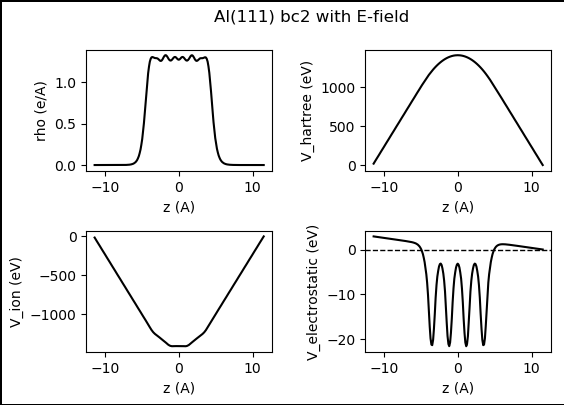

In [552]:
pt.plot_esm1(rjob.prjhome+'/'+rjob.prefixes[0]+'.esm1',titlename='Al(111) bc2 with E-field')

In [553]:
scf_result = {}
extra_result = {}
for prefix in rjob.prefixes:
    scf_result[prefix] = read(rjob.srcout[prefix], index=':', format='espresso-out')
    with open(rjob.srcout[prefix], mode='rt') as fd:
        extra_result[prefix] = read_espresso_extra(fd, index=':')

In [554]:
for prefix in rjob.prefixes:
    for image in scf_result[prefix]:
        calc = image.get_calculator()
        print(calc.get_fermi_level())
        print(image.get_total_energy())
        print(image.get_forces())

-2.5659
-677.440692869739
[[-0.00220498 -0.00125084  0.05317041]
 [ 0.00087469  0.00049982 -0.03569411]
 [-0.0010395  -0.00060035  0.03829812]
 [ 0.00236979  0.00135137 -0.05447885]]


In [555]:
for prefix in rjob.prefixes:
    extra = extra_result[prefix]
    print('***** Total charge from input file *****')
    print("tot_charge = ", f"{extra[-1]['tot_charge']:>12.4f}")
    if extra[-1]['trism'] is True:
        print('***** Chemical potential of solvation from 1D-RISM *****')
        print('                          Closure      Gauss Fluctuation')
        for solvx in extra[-1]['mols']:
            for idy, solvy in enumerate(extra[-1]['mols']):
                if idy == 0:
                    print(f"{solvx:^10}{solvy:^10}{extra[-1]['1d_chem_pot'][solvx][solvy][0]:>16.6f}"
                          f"{extra[-1]['1d_chem_pot'][solvx][solvy][1]:>16.6f}")
                else:
                    print(f"          {solvy:^10}{extra[-1]['1d_chem_pot'][solvx][solvy][0]:>16.6f}"
                          f"{extra[-1]['1d_chem_pot'][solvx][solvy][1]:>16.6f}")
        print('***** Solvent information from 3D/Laue-RISM *****')
        print("Image  solvent    # of solv.    Solv. chg(e).   Chem. pot. (kcal/mol)")
        for idx, image in enumerate(extra[0:-1]):
            for idy, solv in enumerate(extra[-1]['mols']):
                print(f"{idx+1:^5}{solv:^10}{image['solvent_num'][idy]:>12.6f}{image['solvent_chg'][idy]:>16.6f}"
                      f"{image['solvent_pot'][idy]:18.6f}")
    if extra[-1]['lfcp'] is True:
        print('***** FCP information *****')
        for image in extra[0:-1]:
            print("Total charge", f"{image['fcp_current_chg']:12.5f}"," --(next)-->", f"{image['fcp_next_chg']:>12.5f}")
            print("Fermi energy", f"{image['fcp_fermi']:12.5f}", "(eV)")
            print("Force on FCP", f"{image['fcp_force']:12.5f}", "(eV)")

***** Total charge from input file *****
tot_charge =        0.0000


## Al(111) surface ( `bc2` boundary condition with various additional charge)

Here, we will calculate electronic structure at Al(111) charged-surface under `bc2` condition.  In ordinary PBC calculation, the electronic structure at a charged-surface is difficult, because electrostatic terms have diverged terms. Usually, charged cell calculation under the PBC is carried out using assumption of uniform jellium-background. However, this treatment cannot determine electrostatic energy, precisely.  

The treatment of charged cell using ESM method allow us to determine electrostatic energy due to image charge induced at ESM surfaces (for further details can be found in Ref. [1]).   

As following, we introduce additional charge using `tot_charge` value.  

In [556]:
project = 'Al-slab'
prj_info = {
    'project': project,
    'homedir': os.path.expanduser('~')+'/Program',
    'prefixes':  ['Alm2', 'Alm1', 'Al0', 'Alp1', 'Alp2'],
}

In [557]:
job_info = {
    'node':     4,   
    'mpinum':   28,  
    'ompnum':   1,
    'cputime':  dt.timedelta(days=0, hours=0, minutes=30),
    'para_img': 1,
    'para_kpt': 4,
    'para_tsk': 1,
    'para_bnd': 1,
}

In [558]:
rjob = RemoteJob(prj_info, job_info, remote='enemat')

Local working directory (/Users/hagiwara/Program/Al-slab) exists.
File list: Alp1.out  Al0.esm1  Alp2.out  Al_E.out  Alm1.esm1  Al111_bc3_vp015.esm1  sub_Al0.sh  Al_E.inp  Alp2.inp  donejob.txt  Alp1.inp  Alp1.esm1  Al111_bc3_m001.esm1  Al111_bc3_vp015.inp  sub_Alm1.sh  Al111_bc3_m001.out  Al111_bc3_m001.inp  Al111_bc3_vp015.out  job_submit  sub_Alp2.sh  Al_E.esm1  Alm1.out  sub_Alp1.sh  sub_Al111_bc3_vp015.sh  Alm2.out  sub_Al111_bc3_m001.sh  Alm2.inp  Alm1.inp  sub_Alm2.sh  Alp2.esm1  Al0.out  sub_Al_E.sh  Al0.inp  currentjob.txt  Alm2.esm1
Passphrase:········
Password:········


In [559]:
rjob.connecthost()

Remote working directory (/home/otani/hagiwara/tuto/Al-slab) exists.
File list: Al0.inp  Al0.out  Al111_bc3_m001.inp  Al111_bc3_m001.out  Al111_bc3_vp015.inp  Al111_bc3_vp015.out  Al_E.inp  Al_E.out  Alm1.inp  Alm1.out  Alm2.inp  Alm2.out  Alp1.inp  Alp1.out  Alp2.inp  Alp2.out  job_submit  out  sub_Al0.sh  sub_Al111_bc3_m001.sh  sub_Al111_bc3_vp015.sh  sub_Al_E.sh  sub_Alm1.sh  sub_Alm2.sh  sub_Alp1.sh  sub_Alp2.sh  tmp


In [560]:
atoms = Atoms('Al4', [(2.85595455,  0.00000000,  3.49781569),
                      (1.42797727,  0.82444307,  1.16593856),
                      (2.85595454,  1.64888613, -1.16593856),
                      (0.00000000,  0.00000000, -3.49781569)], 
             cell=[( 2.85595455,  0.0000000000,  0.0000000000),
                   ( 1.42797727,  2.4733291965,  0.0000000000),
                   ( 0.00000000,  0.0000000000, 22.9956313827)],
              pbc=(True, True, False)
)
pseudo={'Al':'Al.pbe-n-van.UPF'}

input_data = {
    'control': {
        'calculation'        : 'scf',
        'restart_mode'       : 'from_scratch',
        'prefix'             : 'prefix',
        'max_seconds'        : rjob.maxseconds,
        'pseudo_dir'         : rjob.pseudo,
        'outdir'             : rjob.workdir+'/tmp',
        'tprnfor'            : True,
    },
    'system': {
        'ecutwfc'            : 20.0, 
        'ecutrho'            : 200.0,
        'occupations'        : 'smearing',
        'smearing'           : 'mp',
        'degauss'            : 0.03,
        'nosym'              : True,
        'assume_isolated'    : 'esm',
        'esm_bc'             : 'bc2',
    },
    'electrons': {
        'diagonalization'    : 'rmm',
        'diago_rmm_conv'     : False,
        'mixing_beta'        : 0.3,
    }
}

input_data_chng = {
    rjob.prefixes[0]: {
        'control': {
            'prefix'     : rjob.prefixes[0],
        },
        'system' : {
            'tot_charge' : -0.01,
        },
    },
    rjob.prefixes[1]: {
        'control': {
            'prefix'     : rjob.prefixes[1],
        },
        'system' : {
            'tot_charge' : -0.005,
        },
    },
    rjob.prefixes[2]: {
        'control': {
            'prefix'     : rjob.prefixes[2],
        },
        'system' : {
            'tot_charge' : 0.0,
        }
    },
    rjob.prefixes[3]: {
        'control': {
            'prefix'     : rjob.prefixes[3],
        },
        'system' : {
            'tot_charge' : +0.005,
        },
    },
    rjob.prefixes[4]: {
        'control': {
            'prefix'     : rjob.prefixes[4],
        },
        'system' : {
            'tot_charge' : +0.01,
        }
    },
}

for prefix in rjob.prefixes:
    for group in input_data_chng[prefix]:
        for name, value in input_data_chng[prefix][group].items():
            input_data[group][name] = value
            write(rjob.srcinp[prefix], atoms, format='espresso-in', input_data=input_data, 
                  pseudopotentials=pseudo, kpts=(8, 8, 1), koffset=(1, 1, 0))

In [561]:
view(atoms, viewer='ngl')

In [562]:
rjob.submit_files(prog='pw.x', inpf=rjob.destinp, outf=rjob.destout)

putfiles = [
    rjob.srcsub,
]
putfiles.extend([file for file in rjob.srcinp.values()])
putfiles.extend([file for file in rjob.srcshell.values()])
print('Send files...')
rjob.put_file(putfiles)
for i in range(len(putfiles)):
    print(f"{putfiles[i]} --> {rjob.workdir}")

['#!/bin/bash/sh\n', '#$ -cwd\n', '#$ -pe qall 112\n', '#$ -N H2O\n', '#$ -o out\n', '#$ -e err\n', '#$ -j y\n', 'export OMP_NUM_THREADS=1\n', 'COPY_BASE_DIR', 'mpirun -np 28 /home/otani/hagiwara/q-e-esm-rism61/bin/PROG -nk 4 -nb 1 -nt 1 < INPF > OUTF\n']
None
['#!/bin/bash/sh\n', '#$ -cwd\n', '#$ -pe qall 112\n', '#$ -N H2O\n', '#$ -o out\n', '#$ -e err\n', '#$ -j y\n', 'export OMP_NUM_THREADS=1\n', 'COPY_BASE_DIR', 'mpirun -np 28 /home/otani/hagiwara/q-e-esm-rism61/bin/PROG -nk 4 -nb 1 -nt 1 < INPF > OUTF\n']
None
['#!/bin/bash/sh\n', '#$ -cwd\n', '#$ -pe qall 112\n', '#$ -N H2O\n', '#$ -o out\n', '#$ -e err\n', '#$ -j y\n', 'export OMP_NUM_THREADS=1\n', 'COPY_BASE_DIR', 'mpirun -np 28 /home/otani/hagiwara/q-e-esm-rism61/bin/PROG -nk 4 -nb 1 -nt 1 < INPF > OUTF\n']
None
['#!/bin/bash/sh\n', '#$ -cwd\n', '#$ -pe qall 112\n', '#$ -N H2O\n', '#$ -o out\n', '#$ -e err\n', '#$ -j y\n', 'export OMP_NUM_THREADS=1\n', 'COPY_BASE_DIR', 'mpirun -np 28 /home/otani/hagiwara/q-e-esm-rism61/bin/PR

In [563]:
rjob.submit_job()

['job', 'job', 'job', 'job', 'job']
Submit a job (Alm2), Job ID = job
Submit a job (Alm1), Job ID = job
Submit a job (Al0), Job ID = job
Submit a job (Alp1), Job ID = job
Submit a job (Alp2), Job ID = job


In [564]:
rjob.check_queue()

All jobs are done!


In [577]:
rjob.remote_qstat()

In [576]:
done = {}
for prefix in rjob.prefixes:
    done[prefix] = False
print(f"  Job ID    Done")
for prefix in rjob.prefixes:
    print(f"{rjob.jobid[prefix]:^10}{done[prefix]:^10}")
interval = 20
while True:
    print(f"...refresh after {interval} seconds...")
    time.sleep(interval)
    rjob.check_job(done)
    if all(done.values()):
        break
    for prefix in rjob.prefixes:
        print(f"{rjob.jobid[prefix]:^10}{done[prefix]:^10}")
for prefix in rjob.prefixes:
    print(f"{rjob.jobid[prefix]:^10}{done[prefix]:^10}")
print("Job done!")

  Job ID    Done
   job        0     
   job        0     
   job        0     
   job        0     
   job        0     
...refresh after 20 seconds...
   job        1     
   job        1     
   job        1     
   job        1     
   job        1     
Job done!


In [578]:
getfiles = []
getfiles.extend([file for file in rjob.destout.values()])
getfiles.extend([file for file in rjob.destesm1.values()])
print('Get files...')
rjob.get_file(getfiles)
for i in range(len(getfiles)):
    print("{0} --> {1}".format(getfiles[i], rjob.prjhome))

Get files...
/home/otani/hagiwara/tuto/Al-slab/Alm2.out --> /Users/hagiwara/Program/Al-slab
/home/otani/hagiwara/tuto/Al-slab/Alm1.out --> /Users/hagiwara/Program/Al-slab
/home/otani/hagiwara/tuto/Al-slab/Al0.out --> /Users/hagiwara/Program/Al-slab
/home/otani/hagiwara/tuto/Al-slab/Alp1.out --> /Users/hagiwara/Program/Al-slab
/home/otani/hagiwara/tuto/Al-slab/Alp2.out --> /Users/hagiwara/Program/Al-slab
/home/otani/hagiwara/tuto/Al-slab/tmp/Alm2.esm1 --> /Users/hagiwara/Program/Al-slab
/home/otani/hagiwara/tuto/Al-slab/tmp/Alm1.esm1 --> /Users/hagiwara/Program/Al-slab
/home/otani/hagiwara/tuto/Al-slab/tmp/Al0.esm1 --> /Users/hagiwara/Program/Al-slab
/home/otani/hagiwara/tuto/Al-slab/tmp/Alp1.esm1 --> /Users/hagiwara/Program/Al-slab
/home/otani/hagiwara/tuto/Al-slab/tmp/Alp2.esm1 --> /Users/hagiwara/Program/Al-slab


* Copy BASE calculation result (typically charge netural calculation) to BASE directory for later use

In [579]:
source_dir = rjob.workdir+'/tmp/'+rjob.prefixes[2]+'.save'
rjob.set_base(source_dir, rjob.baseesm)

BASE directory exists -> Remove & Copy /home/otani/hagiwara/tuto/Al-slab/tmp/BASE.ESM


* Distribute BASE data from BASE directory to all calculations (use WF and Pot as a initial)

### Plot the results of density and potentials at the various charged surface

Here, we plot the results of laterally averaged electronic density and potentials.  
For total charge zero, the results of them are the almost same as those with `bc1` calculation. 

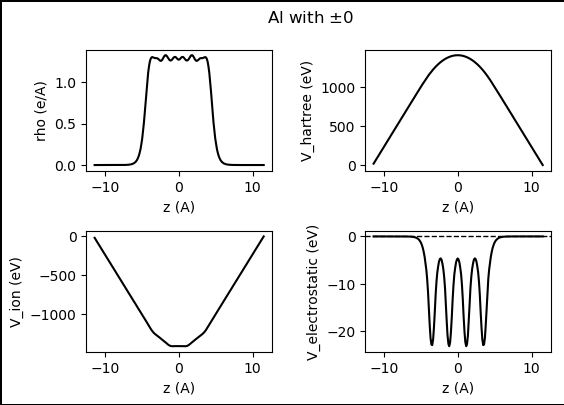

In [580]:
pt.plot_esm1(rjob.prjhome+'/'+rjob.prefixes[2]+'.esm1',titlename=r'Al with $\pm$0')

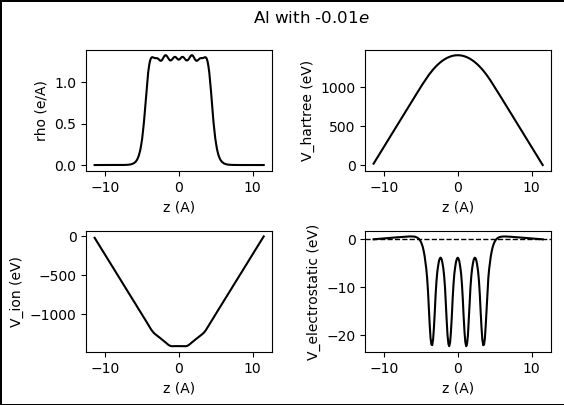

In [449]:
pt.plot_esm1(rjob.prjhome+'/'+rjob.prefixes[0]+'.esm1',titlename=r'Al with -0.01$e$')

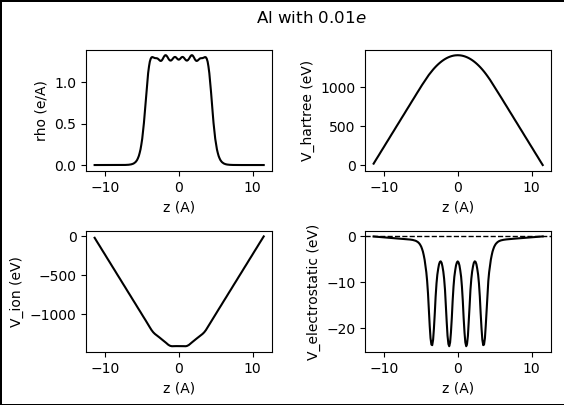

In [450]:
pt.plot_esm1(rjob.prjhome+'/'+rjob.prefixes[4]+'.esm1',titlename=r'Al with 0.01$e$')

### Differential potential

Here, we plot the electrostatic potential difference between non-charged and charged surfaces.  

The induced electric field by additional charge can be clearly seen as followings.  
Furthermore, we found that the potential in the charged slab is almost uniform.  
This result is caused by electron screening effect to the external field.    

In this calculation, unfortunately, induced potential in slab region slightly oscilates.  
This oscilation is caused by insufficient FFT grids. 
If you increase cut-off energy and carry out convergence study, 
this oscilation can be removed. 

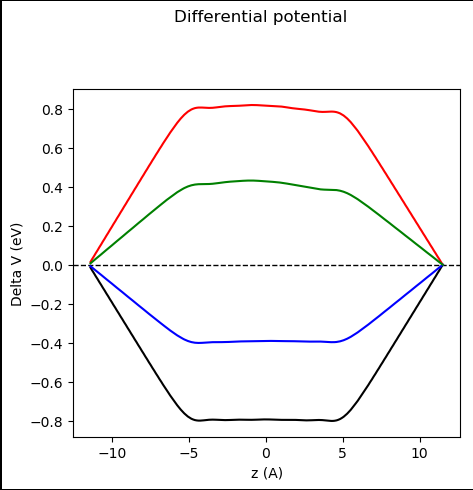

In [582]:
m2 = np.loadtxt(rjob.prjhome+'/'+rjob.prefixes[0]+'.esm1',comments='#')
m1 = np.loadtxt(rjob.prjhome+'/'+rjob.prefixes[1]+'.esm1',comments='#')
n0 = np.loadtxt(rjob.prjhome+'/'+rjob.prefixes[2]+'.esm1',comments='#')
p1 = np.loadtxt(rjob.prjhome+'/'+rjob.prefixes[3]+'.esm1',comments='#')
p2 = np.loadtxt(rjob.prjhome+'/'+rjob.prefixes[4]+'.esm1',comments='#')
fig = plt.figure(
    figsize   = (5,5), # inch
#    dpi       = 100,    # dpi
#    edgecolor = 'black',
#   linewidth = '1'
)
fig.subplots_adjust(wspace=0.3, hspace=0.5,top=0.82)
fig.suptitle('Differential potential')

ax = fig.add_subplot(111)
ax.set_xlabel('z (A)')
ax.set_ylabel('Delta V (eV)')
ax.axhline(0.0, linewidth=1, linestyle='dashed', color='black')
ax.plot(n0[:,0], p2[:,4]-n0[:,4], color='black', linestyle='solid', label='+0.01e')
ax.plot(n0[:,0], m2[:,4]-n0[:,4], color='red', linestyle='solid', label='-0.01e')
ax.plot(n0[:,0], p1[:,4]-n0[:,4], color='blue', linestyle='solid', label='+0.005e')
ax.plot(n0[:,0], m1[:,4]-n0[:,4], color='green', linestyle='solid',label='-0.005e')
plt.show()

In [583]:
scf_result = {}
extra_result = {}
for prefix in rjob.prefixes:
    scf_result[prefix] = read(rjob.srcout[prefix], index=':', format='espresso-out')
    with open(rjob.srcout[prefix], mode='rt') as fd:
        extra_result[prefix] = read_espresso_extra(fd, index=':')

In [591]:
print('---------------------------')

for prefix in rjob.prefixes:
    for image in scf_result[prefix]:
#        calc = image.get_calculator()
#        print(calc.get_fermi_level())
        print('Total energy (eV): '+str(image.get_total_energy()))
        print('---------------------------')
        print('Forces acting on atoms (Ry/Bohr)')
        print('---------------------------')
        print(image.get_forces())
        print('---------------------------')



---------------------------
Total energy (eV): -677.4708316542809
---------------------------
Forces acting on atoms (Ry/Bohr)
---------------------------
[[-0.0022384  -0.00129147  0.05623851]
 [ 0.00091094  0.00052502 -0.03637237]
 [-0.00090426 -0.00052219  0.03601421]
 [ 0.00223172  0.00128889 -0.05618349]]
---------------------------
Total energy (eV): -677.4536212703274
---------------------------
Forces acting on atoms (Ry/Bohr)
---------------------------
[[-0.0022546  -0.00130021  0.05540444]
 [ 0.00096005  0.00055356 -0.03786618]
 [-0.00094359 -0.0005515   0.03744606]
 [ 0.0022384   0.00129815 -0.05523475]]
---------------------------
Total energy (eV): -677.4344508503941
---------------------------
Forces acting on atoms (Ry/Bohr)
---------------------------
[[-0.00231374 -0.00133569  0.05299789]
 [ 0.00094745  0.00054533 -0.03819657]
 [-0.00094822 -0.00054816  0.03826959]
 [ 0.00231451  0.00133852 -0.05301666]]
---------------------------
Total energy (eV): -677.413292502812

In [592]:
for prefix in rjob.prefixes:
    extra = extra_result[prefix]
    print('***** Total charge from input file *****')
    print("tot_charge = ", f"{extra[-1]['tot_charge']:>12.4f}")
    if extra[-1]['trism'] is True:
        print('***** Chemical potential of solvation from 1D-RISM *****')
        print('                          Closure      Gauss Fluctuation')
        for solvx in extra[-1]['mols']:
            for idy, solvy in enumerate(extra[-1]['mols']):
                if idy == 0:
                    print(f"{solvx:^10}{solvy:^10}{extra[-1]['1d_chem_pot'][solvx][solvy][0]:>16.6f}"
                          f"{extra[-1]['1d_chem_pot'][solvx][solvy][1]:>16.6f}")
                else:
                    print(f"          {solvy:^10}{extra[-1]['1d_chem_pot'][solvx][solvy][0]:>16.6f}"
                          f"{extra[-1]['1d_chem_pot'][solvx][solvy][1]:>16.6f}")
        print('***** Solvent information from 3D/Laue-RISM *****')
        print("Image  solvent    # of solv.    Solv. chg(e).   Chem. pot. (kcal/mol)")
        for idx, image in enumerate(extra[0:-1]):
            for idy, solv in enumerate(extra[-1]['mols']):
                print(f"{idx+1:^5}{solv:^10}{image['solvent_num'][idy]:>12.6f}{image['solvent_chg'][idy]:>16.6f}"
                      f"{image['solvent_pot'][idy]:18.6f}")
    if extra[-1]['lfcp'] is True:
        print('***** FCP information *****')
        for image in extra[0:-1]:
            print("Total charge", f"{image['fcp_current_chg']:12.5f}"," --(next)-->", f"{image['fcp_next_chg']:>12.5f}")
            print("Fermi energy", f"{image['fcp_fermi']:12.5f}", "(eV)")
            print("Force on FCP", f"{image['fcp_force']:12.5f}", "(eV)")

***** Total charge from input file *****
tot_charge =       -0.0100
***** Total charge from input file *****
tot_charge =       -0.0050
***** Total charge from input file *****
tot_charge =        0.0000
***** Total charge from input file *****
tot_charge =        0.0050
***** Total charge from input file *****
tot_charge =        0.0100


## Al(111) surface ('bc3' boundary condition with additional charge [-0.01e])

Here, we learn the vacuum/slab/metal boundary condition calculation.  
Surface slab is sandwiched by the semi-infinite vacuum and metal ESM.  
In this boundary condition, if we set the extra charge, image charge is induced at the metal ESM. 
Thus, electric field is induced only metal side.  

In this calculation, we use `bc3` condition. 

In [593]:
project = 'Al-slab'
prj_info = {
    'project': project,
    'homedir': os.path.expanduser('~')+'/Program',
    'prefixes':  ['Al111_bc3_m001'],
}

job_info = {
    'node':     4,   
    'mpinum':   28,  
    'ompnum':   1,
    'cputime':  dt.timedelta(days=0, hours=0, minutes=30),
    'para_img': 1,
    'para_kpt': 4,
    'para_tsk': 1,
    'para_bnd': 1,
}

rjob = RemoteJob(prj_info, job_info, remote='enemat')

rjob.connecthost()

Local working directory (/Users/hagiwara/Program/Al-slab) exists.
File list: Alp1.out  Al0.esm1  Alp2.out  Al_E.out  Alm1.esm1  Al111_bc3_vp015.esm1  sub_Al0.sh  Al_E.inp  Alp2.inp  donejob.txt  Alp1.inp  Alp1.esm1  Al111_bc3_m001.esm1  Al111_bc3_vp015.inp  sub_Alm1.sh  Al111_bc3_m001.out  Al111_bc3_m001.inp  Al111_bc3_vp015.out  job_submit  sub_Alp2.sh  Al_E.esm1  Alm1.out  sub_Alp1.sh  sub_Al111_bc3_vp015.sh  Alm2.out  sub_Al111_bc3_m001.sh  Alm2.inp  Alm1.inp  sub_Alm2.sh  Alp2.esm1  Al0.out  sub_Al_E.sh  Al0.inp  currentjob.txt  Alm2.esm1
Passphrase:········
Password:········
Remote working directory (/home/otani/hagiwara/tuto/Al-slab) exists.
File list: Al0.inp  Al0.out  Al111_bc3_m001.inp  Al111_bc3_m001.out  Al111_bc3_vp015.inp  Al111_bc3_vp015.out  Al_E.inp  Al_E.out  Alm1.inp  Alm1.out  Alm2.inp  Alm2.out  Alp1.inp  Alp1.out  Alp2.inp  Alp2.out  job_submit  out  sub_Al0.sh  sub_Al111_bc3_m001.sh  sub_Al111_bc3_vp015.sh  sub_Al_E.sh  sub_Alm1.sh  sub_Alm2.sh  sub_Alp1.sh  sub_A

In [594]:
atoms = Atoms('Al4', [(2.85595455,  0.00000000,  3.49781569),
                      (1.42797727,  0.82444307,  1.16593856),
                      (2.85595454,  1.64888613, -1.16593856),
                      (0.00000000,  0.00000000, -3.49781569)], 
             cell=[( 2.85595455,  0.0000000000,  0.0000000000),
                   ( 1.42797727,  2.4733291965,  0.0000000000),
                   ( 0.00000000,  0.0000000000, 22.9956313827)],
              pbc=(True, True, False)
)
pseudo={'Al':'Al.pbe-n-van.UPF'}

input_data = {
    'control': {
        'calculation'        : 'scf',
        'restart_mode'       : 'from_scratch',
        'prefix'             : prefix,
        'pseudo_dir'         : rjob.pseudo,
        'outdir'             : rjob.workdir+'/tmp',
        'tprnfor'            : True,
    },
    'system': {
        'ecutwfc'            : 20.0, 
        'ecutrho'            : 200.0,
        'occupations'        : 'smearing',
        'smearing'           : 'mp',
        'degauss'            : 0.03,
        'nosym'              : True,
        'assume_isolated'    : 'esm',
        'esm_bc'             : 'bc3',
        'tot_charge'         : -0.01
    },
    'electrons': {
        'mixing_beta'        : 0.5,
    }
}

input_data_chng = {
    rjob.prefixes[0]: {
        'control': {
            'prefix'     : rjob.prefixes[0],
        },
    },
}

for prefix in rjob.prefixes:
    for group in input_data_chng[prefix]:
        for name, value in input_data_chng[prefix][group].items():
            input_data[group][name] = value
            write(rjob.srcinp[prefix], atoms, format='espresso-in', input_data=input_data, 
                  pseudopotentials=pseudo, kpts=(8, 8, 1), koffset=(1, 1, 0))

In [595]:
view(atoms, viewer='ngl')

In [596]:
rjob.submit_files(prog='pw.x', inpf=rjob.destinp, outf=rjob.destout)

putfiles = [
    rjob.srcsub,
]
putfiles.extend([file for file in rjob.srcinp.values()])
putfiles.extend([file for file in rjob.srcshell.values()])
print('Send files...')
rjob.put_file(putfiles)
for i in range(len(putfiles)):
    print(f"{putfiles[i]} --> {rjob.workdir}")

['#!/bin/bash/sh\n', '#$ -cwd\n', '#$ -pe qall 112\n', '#$ -N H2O\n', '#$ -o out\n', '#$ -e err\n', '#$ -j y\n', 'export OMP_NUM_THREADS=1\n', 'COPY_BASE_DIR', 'mpirun -np 28 /home/otani/hagiwara/q-e-esm-rism61/bin/PROG -nk 4 -nb 1 -nt 1 < INPF > OUTF\n']
None
Send files...
/Users/hagiwara/Program/Al-slab/job_submit --> /home/otani/hagiwara/tuto/Al-slab
/Users/hagiwara/Program/Al-slab/Al111_bc3_m001.inp --> /home/otani/hagiwara/tuto/Al-slab
/Users/hagiwara/Program/Al-slab/sub_Al111_bc3_m001.sh --> /home/otani/hagiwara/tuto/Al-slab


In [597]:
rjob.submit_job()

['job']
Submit a job (Al111_bc3_m001), Job ID = job


In [605]:
rjob.remote_qstat()

In [606]:
done = {}
for prefix in rjob.prefixes:
    done[prefix] = False
print(f"  Job ID    Done")
for prefix in rjob.prefixes:
    print(f"{rjob.jobid[prefix]:^10}{done[prefix]:^10}")
interval = 20
while True:
    print(f"...refresh after {interval} seconds...")
    time.sleep(interval)
    rjob.check_job(done)
    if all(done.values()):
        break
    for prefix in rjob.prefixes:
        print(f"{rjob.jobid[prefix]:^10}{done[prefix]:^10}")
for prefix in rjob.prefixes:
    print(f"{rjob.jobid[prefix]:^10}{done[prefix]:^10}")
print("Job done!")

getfiles = []
getfiles.extend([file for file in rjob.destout.values()])
getfiles.extend([file for file in rjob.destesm1.values()])
print('Get files...')
rjob.get_file(getfiles)
for i in range(len(getfiles)):
    print("{0} --> {1}".format(getfiles[i], rjob.prjhome))

source_dir = rjob.workdir+'/tmp/'+rjob.prefixes[0]+'.save'
rjob.set_base(source_dir, rjob.baseesm)

print("Preparation for esm plot is done.")

  Job ID    Done
   job        0     
...refresh after 20 seconds...
   job        1     
Job done!
Get files...
/home/otani/hagiwara/tuto/Al-slab/Al111_bc3_m001.out --> /Users/hagiwara/Program/Al-slab
/home/otani/hagiwara/tuto/Al-slab/tmp/Al111_bc3_m001.esm1 --> /Users/hagiwara/Program/Al-slab
BASE directory exists -> Remove & Copy /home/otani/hagiwara/tuto/Al-slab/tmp/BASE.ESM
Preparation for esm plot is done.


### Plot electrostatic potentials

Here, we also plot electrostatic potentials. Origin of electrostatic potential is chosen as the metal ESM surface. 

We clearly found that the electric field is induced for the only side of metal ESM.  

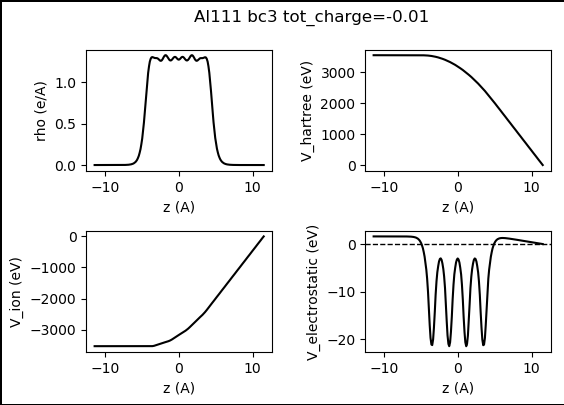

In [607]:
pt.plot_esm1(rjob.prjhome+'/'+rjob.prefixes[0]+'.esm1',titlename='Al111 bc3 tot_charge=-0.01')

## Al(111) surface ('bc3' boundary condition with constant-mu scheme [target_mu=+1.5 vs PZC])

Here, we learn the how to use the constant-$\mu_{\rm e}$ calculation.   
In this calculation target $\mu_{\rm e}$ is set to +1.5eV comparing to that of  potential zero charge.  
Theoretical back-ground can be learn the published elsewhere [N. Bonnet et al., Phys. Rev. Lett. 109, 266101 (2012).].
This computational technique is very important for investigating the electrochemical interface, because conventional DFT calculation can simulate *only constant-N* calculation. However, in the electrochemical interface, constant-$\mu_{\rm e}$ calculation is required due to the existance of the potentiostat.  

We use `bc3` boundary condition. Thus, Al surface is connected with the metal ESM via the external potentiostat. 

In [608]:
project = 'Al-slab'
prj_info = {
    'project': project,
    'homedir': os.path.expanduser('~')+'/Program',
    'prefixes':  ['Al111_bc3_vp015'],
}

job_info = {
    'node':     4,   
    'mpinum':   28,  
    'ompnum':   1,
    'cputime':  dt.timedelta(days=0, hours=0, minutes=30),
    'para_img': 1,
    'para_kpt': 4,
    'para_tsk': 1,
    'para_bnd': 1,
}

rjob = RemoteJob(prj_info, job_info, remote='enemat')

rjob.connecthost()

Local working directory (/Users/hagiwara/Program/Al-slab) exists.
File list: Alp1.out  Al0.esm1  Alp2.out  Al_E.out  Alm1.esm1  Al111_bc3_vp015.esm1  sub_Al0.sh  Al_E.inp  Alp2.inp  donejob.txt  Alp1.inp  Alp1.esm1  Al111_bc3_m001.esm1  Al111_bc3_vp015.inp  sub_Alm1.sh  Al111_bc3_m001.out  Al111_bc3_m001.inp  Al111_bc3_vp015.out  job_submit  sub_Alp2.sh  Al_E.esm1  Alm1.out  sub_Alp1.sh  sub_Al111_bc3_vp015.sh  Alm2.out  sub_Al111_bc3_m001.sh  Alm2.inp  Alm1.inp  sub_Alm2.sh  Alp2.esm1  Al0.out  sub_Al_E.sh  Al0.inp  currentjob.txt  Alm2.esm1
Passphrase:········
Password:········
Remote working directory (/home/otani/hagiwara/tuto/Al-slab) exists.
File list: Al0.inp  Al0.out  Al111_bc3_m001.inp  Al111_bc3_m001.out  Al111_bc3_vp015.inp  Al111_bc3_vp015.out  Al_E.inp  Al_E.out  Alm1.inp  Alm1.out  Alm2.inp  Alm2.out  Alp1.inp  Alp1.out  Alp2.inp  Alp2.out  job_submit  out  sub_Al0.sh  sub_Al111_bc3_m001.sh  sub_Al111_bc3_vp015.sh  sub_Al_E.sh  sub_Alm1.sh  sub_Alm2.sh  sub_Alp1.sh  sub_A

### Input file for constant-$\mu_{\rm e}$ calculation

Here, we briefly describe input values used in constant-$\mu_{\rm e}$ calculation.  
It is noted that the input values are slightly differ from original quantum espresso code.  
More detailed descriptions of inputs can be found in `/QE/PW/Doc/Input_PW.html`.

Below is input creation code with ASE. We can found three new input vaules and one input card:  

* `&FCP` ... This is an input card for contlolling the details of constant-$\mu_{\rm e}$ calculation. This card is activated by `lfcp=.true.`  
* `lfcp` ... Activation flag for constant-$\mu_{\rm e}$ calculation. 
* `fcp_mu` ... This value determine the target $\mu_{\rm e}$ (in eV). 
* `fcp_dynamics` ... dynamics used in the calculation, which should be same as `ion_dynamics` value. 

In addition to the above, we use the `tot_charge = -0.01e`. 


NOTE: to decrease computational costs, we use fixed atomic positions.  

In [609]:
from ase.constraints import FixAtoms

atoms = Atoms('Al4', [(2.85595455,  0.00000000,  3.49781569),
                      (1.42797727,  0.82444307,  1.16593856),
                      (2.85595454,  1.64888613, -1.16593856),
                      (0.00000000,  0.00000000, -3.49781569)], 
             cell=[( 2.85595455,  0.0000000000,  0.0000000000),
                   ( 1.42797727,  2.4733291965,  0.0000000000),
                   ( 0.00000000,  0.0000000000, 22.9956313827)],
              pbc=(True, True, False)
)
# All Al atoms are
c = FixAtoms(mask=[atom.symbol == 'Al' for atom in atoms])
atoms.set_constraint(c)

pseudo={'Al':'Al.pbe-n-van.UPF'}

input_data = {
    'control': {
        'calculation'        : 'relax',
        'restart_mode'       : 'from_scratch',
        'prefix'             : prefix,
        'pseudo_dir'         : rjob.pseudo,
        'outdir'             : rjob.workdir+'/tmp',
        'tprnfor'            : True,
        'lfcp'               : True,
    },
    'system': {
        'ecutwfc'            : 20.0, 
        'ecutrho'            : 200.0,
        'occupations'        : 'smearing',
        'smearing'           : 'mp',
        'degauss'            : 0.03,
        'nosym'              : True,
        'assume_isolated'    : 'esm',
        'esm_bc'             : 'bc3',
        'tot_charge'         : -0.01,      # Acceralate convergence with good starting tot_charge
    },
    'electrons': {
        'mixing_beta'        : 0.5,
    },
    'ions': {
        'ion_dynamics'       : 'damp',
    },
    'fcp': {
        'fcp_mu'             : -2.5610, # eV -> 1.5 eV above the PZC(=-4.0610) that corresponding to negative value of workfunction at Al(111)
        'fcp_dynamics'       : 'damp',
    }
}

input_data_chng = {
    rjob.prefixes[0]: {
        'control': {
            'prefix'     : rjob.prefixes[0],
        },
    },
}

for prefix in rjob.prefixes:
    for group in input_data_chng[prefix]:
        for name, value in input_data_chng[prefix][group].items():
            input_data[group][name] = value
            write(rjob.srcinp[prefix], atoms, format='espresso-in', input_data=input_data, 
                  pseudopotentials=pseudo, kpts=(8, 8, 1), koffset=(1, 1, 0))

In [610]:
rjob.submit_files(prog='pw.x', inpf=rjob.destinp, outf=rjob.destout)

putfiles = [
    rjob.srcsub,
]
putfiles.extend([file for file in rjob.srcinp.values()])
putfiles.extend([file for file in rjob.srcshell.values()])
print('Send files...')
rjob.put_file(putfiles)
for i in range(len(putfiles)):
    print(f"{putfiles[i]} --> {rjob.workdir}")

['#!/bin/bash/sh\n', '#$ -cwd\n', '#$ -pe qall 112\n', '#$ -N H2O\n', '#$ -o out\n', '#$ -e err\n', '#$ -j y\n', 'export OMP_NUM_THREADS=1\n', 'COPY_BASE_DIR', 'mpirun -np 28 /home/otani/hagiwara/q-e-esm-rism61/bin/PROG -nk 4 -nb 1 -nt 1 < INPF > OUTF\n']
None
Send files...
/Users/hagiwara/Program/Al-slab/job_submit --> /home/otani/hagiwara/tuto/Al-slab
/Users/hagiwara/Program/Al-slab/Al111_bc3_vp015.inp --> /home/otani/hagiwara/tuto/Al-slab
/Users/hagiwara/Program/Al-slab/sub_Al111_bc3_vp015.sh --> /home/otani/hagiwara/tuto/Al-slab


In [611]:
rjob.submit_job()

['job']
Submit a job (Al111_bc3_vp015), Job ID = job


In [623]:
rjob.remote_qstat()

In [624]:
done = {}
for prefix in rjob.prefixes:
    done[prefix] = False
print(f"  Job ID    Done")
for prefix in rjob.prefixes:
    print(f"{rjob.jobid[prefix]:^10}{done[prefix]:^10}")
interval = 20
while True:
    print(f"...refresh after {interval} seconds...")
    time.sleep(interval)
    rjob.check_job(done)
    if all(done.values()):
        break
    for prefix in rjob.prefixes:
        print(f"{rjob.jobid[prefix]:^10}{done[prefix]:^10}")
for prefix in rjob.prefixes:
    print(f"{rjob.jobid[prefix]:^10}{done[prefix]:^10}")
print("Job done!")

getfiles = []
getfiles.extend([file for file in rjob.destout.values()])
getfiles.extend([file for file in rjob.destesm1.values()])
print('Get files...')
rjob.get_file(getfiles)
for i in range(len(getfiles)):
    print("{0} --> {1}".format(getfiles[i], rjob.prjhome))

source_dir = rjob.workdir+'/tmp/'+rjob.prefixes[0]+'.save'
rjob.set_base(source_dir, rjob.baseesm)

print("Preparation for esm plot is done.")

  Job ID    Done
   job        0     
...refresh after 20 seconds...
   job        1     
Job done!
Get files...
/home/otani/hagiwara/tuto/Al-slab/Al111_bc3_vp015.out --> /Users/hagiwara/Program/Al-slab
/home/otani/hagiwara/tuto/Al-slab/tmp/Al111_bc3_vp015.esm1 --> /Users/hagiwara/Program/Al-slab
BASE directory exists -> Remove & Copy /home/otani/hagiwara/tuto/Al-slab/tmp/BASE.ESM
Preparation for esm plot is done.


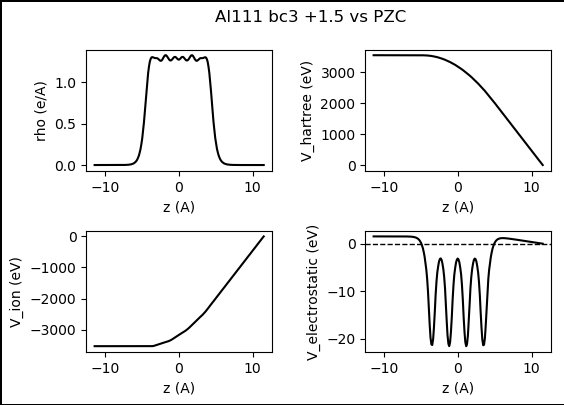

In [625]:
pt.plot_esm1(rjob.prjhome+'/'+rjob.prefixes[0]+'.esm1',titlename='Al111 bc3 +1.5 vs PZC')

## Al(111) surface ('bc3' boundary condition with constant-mu scheme [target_mu=-1.5 vs PZC])

In [626]:
project = 'Al-slab'
prj_info = {
    'project': project,
    'homedir': os.path.expanduser('~')+'/Program',
    'prefixes':  ['Al111_bc3_vp015'],
}

job_info = {
    'node':     4,   
    'mpinum':   28,  
    'ompnum':   1,
    'cputime':  dt.timedelta(days=0, hours=0, minutes=30),
    'para_img': 1,
    'para_kpt': 4,
    'para_tsk': 1,
    'para_bnd': 1,
}

rjob = RemoteJob(prj_info, job_info, remote='enemat')

print('Connecting to RemoteHost...')
rjob.connecthost()

atoms = Atoms('Al4', [(2.85595455,  0.00000000,  3.49781569),
                      (1.42797727,  0.82444307,  1.16593856),
                      (2.85595454,  1.64888613, -1.16593856),
                      (0.00000000,  0.00000000, -3.49781569)], 
             cell=[( 2.85595455,  0.0000000000,  0.0000000000),
                   ( 1.42797727,  2.4733291965,  0.0000000000),
                   ( 0.00000000,  0.0000000000, 22.9956313827)],
              pbc=(True, True, False)
)
#c = FixAtoms(mask=[atom.symbol == 'Al' for atom in atoms])
#atoms.set_constraint(c)

pseudo={'Al':'Al.pbe-n-van.UPF'}

input_data = {
    'control': {
        'calculation'        : 'relax',
        'restart_mode'       : 'from_scratch',
        'prefix'             : prefix,
        'pseudo_dir'         : rjob.pseudo,
        'outdir'             : rjob.workdir+'/tmp',
        'tprnfor'            : True,
        'lfcp'               : True,
    },
    'system': {
        'ecutwfc'            : 20.0, 
        'ecutrho'            : 200.0,
        'occupations'        : 'smearing',
        'smearing'           : 'mp',
        'degauss'            : 0.03,
        'nosym'              : True,
        'assume_isolated'    : 'esm',
        'esm_bc'             : 'bc3',
        'tot_charge'         : 0.01,      # Acceralate convergence with good starting tot_charge
    },
    'electrons': {
        'mixing_beta'        : 0.5,
    },
    'ions': {
        'ion_dynamics'       : 'damp',
    },
    'fcp': {
        'fcp_mu'             : -5.5610, # eV -> 1.5 eV below the PZC(=-4.0610)
        'fcp_dynamics'       : 'damp',
        'freeze_all_atoms'   : True, # Another way to fix the atomic position. See above cell which uses constraint.
    }
}

for prefix in rjob.prefixes:
    for group in input_data_chng[prefix]:
        for name, value in input_data_chng[prefix][group].items():
            input_data[group][name] = value
            write(rjob.srcinp[prefix], atoms, format='espresso-in', input_data=input_data, 
                  pseudopotentials=pseudo, kpts=(8, 8, 1), koffset=(1, 1, 0))
            
print('InputFile generation was done.')

Local working directory (/Users/hagiwara/Program/Al-slab) exists.
File list: Alp1.out  Al0.esm1  Alp2.out  Al_E.out  Alm1.esm1  Al111_bc3_vp015.esm1  sub_Al0.sh  Al_E.inp  Alp2.inp  donejob.txt  Alp1.inp  Alp1.esm1  Al111_bc3_m001.esm1  Al111_bc3_vp015.inp  sub_Alm1.sh  Al111_bc3_m001.out  Al111_bc3_m001.inp  Al111_bc3_vp015.out  job_submit  sub_Alp2.sh  Al_E.esm1  Alm1.out  sub_Alp1.sh  sub_Al111_bc3_vp015.sh  Alm2.out  sub_Al111_bc3_m001.sh  Alm2.inp  Alm1.inp  sub_Alm2.sh  Alp2.esm1  Al0.out  sub_Al_E.sh  Al0.inp  currentjob.txt  Alm2.esm1
Passphrase:········
Password:········
Connecting to RemoteHost...
Remote working directory (/home/otani/hagiwara/tuto/Al-slab) exists.
File list: Al0.inp  Al0.out  Al111_bc3_m001.inp  Al111_bc3_m001.out  Al111_bc3_vp015.inp  Al111_bc3_vp015.out  Al_E.inp  Al_E.out  Alm1.inp  Alm1.out  Alm2.inp  Alm2.out  Alp1.inp  Alp1.out  Alp2.inp  Alp2.out  job_submit  out  sub_Al0.sh  sub_Al111_bc3_m001.sh  sub_Al111_bc3_vp015.sh  sub_Al_E.sh  sub_Alm1.sh  sub

In [627]:
rjob.submit_files(prog='pw.x', inpf=rjob.destinp, outf=rjob.destout)

putfiles = [
    rjob.srcsub,
]
putfiles.extend([file for file in rjob.srcinp.values()])
putfiles.extend([file for file in rjob.srcshell.values()])
print('Send files...')
rjob.put_file(putfiles)
for i in range(len(putfiles)):
    print(f"{putfiles[i]} --> {rjob.workdir}")
rjob.submit_job()

['#!/bin/bash/sh\n', '#$ -cwd\n', '#$ -pe qall 112\n', '#$ -N H2O\n', '#$ -o out\n', '#$ -e err\n', '#$ -j y\n', 'export OMP_NUM_THREADS=1\n', 'COPY_BASE_DIR', 'mpirun -np 28 /home/otani/hagiwara/q-e-esm-rism61/bin/PROG -nk 4 -nb 1 -nt 1 < INPF > OUTF\n']
None
Send files...
/Users/hagiwara/Program/Al-slab/job_submit --> /home/otani/hagiwara/tuto/Al-slab
/Users/hagiwara/Program/Al-slab/Al111_bc3_vp015.inp --> /home/otani/hagiwara/tuto/Al-slab
/Users/hagiwara/Program/Al-slab/sub_Al111_bc3_vp015.sh --> /home/otani/hagiwara/tuto/Al-slab
['job']
Submit a job (Al111_bc3_vp015), Job ID = job


In [635]:
rjob.remote_qstat()

  Job ID    Done
   job        0     
...refresh after 20 seconds...
   job        1     
Job done!
Get files...
/home/otani/hagiwara/tuto/Al-slab/Al111_bc3_vp015.out --> /Users/hagiwara/Program/Al-slab
/home/otani/hagiwara/tuto/Al-slab/tmp/Al111_bc3_vp015.esm1 --> /Users/hagiwara/Program/Al-slab
BASE directory exists -> Remove & Copy /home/otani/hagiwara/tuto/Al-slab/tmp/BASE.ESM
Preparation for esm plot is done.


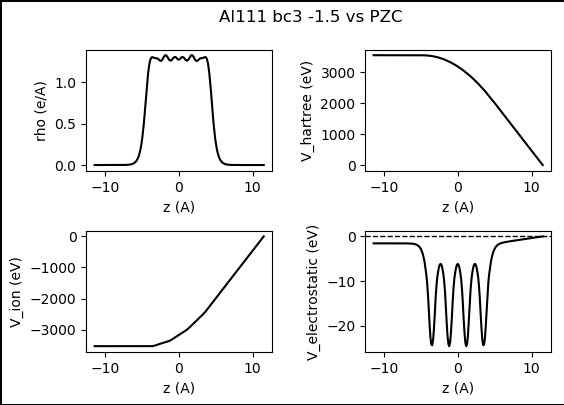

In [636]:
done = {}
for prefix in rjob.prefixes:
    done[prefix] = False
print(f"  Job ID    Done")
for prefix in rjob.prefixes:
    print(f"{rjob.jobid[prefix]:^10}{done[prefix]:^10}")
interval = 20
while True:
    print(f"...refresh after {interval} seconds...")
    time.sleep(interval)
    rjob.check_job(done)
    if all(done.values()):
        break
    for prefix in rjob.prefixes:
        print(f"{rjob.jobid[prefix]:^10}{done[prefix]:^10}")
for prefix in rjob.prefixes:
    print(f"{rjob.jobid[prefix]:^10}{done[prefix]:^10}")
print("Job done!")

getfiles = []
getfiles.extend([file for file in rjob.destout.values()])
getfiles.extend([file for file in rjob.destesm1.values()])
print('Get files...')
rjob.get_file(getfiles)
for i in range(len(getfiles)):
    print("{0} --> {1}".format(getfiles[i], rjob.prjhome))

source_dir = rjob.workdir+'/tmp/'+rjob.prefixes[0]+'.save'
rjob.set_base(source_dir, rjob.baseesm)

print("Preparation for esm plot is done.")

FilePath=rjob.prjhome+'/'+rjob.prefixes[0]+'.esm1'
pt.plot_esm1(FilePath,titlename='Al111 bc3 -1.5 vs PZC')

## Differential potential

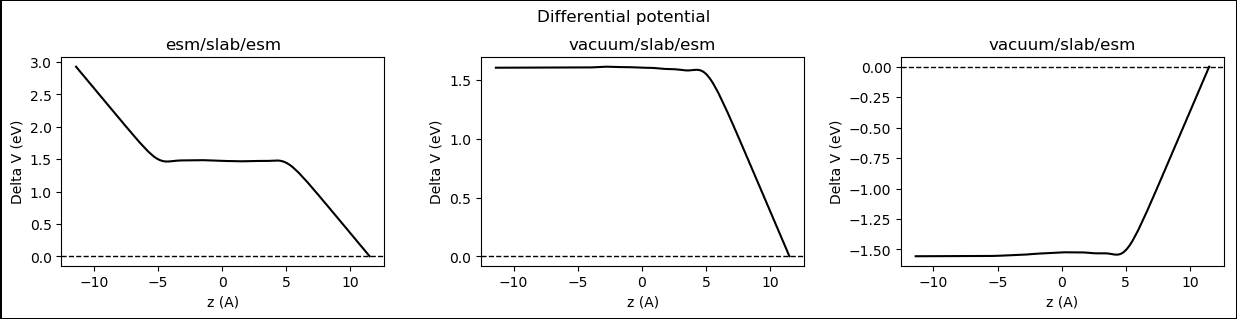

In [638]:
work_path=rjob.prjhome+'/'
bc1 = np.loadtxt(work_path+'Al0.esm1',comments='#')
bc2 = np.loadtxt(work_path+'Al_E.esm1',comments='#')
bc3_vm = np.loadtxt(work_path+'Al111_bc3_m001.esm1')
bc3_vp = np.loadtxt(work_path+'Al111_bc3_vp015.esm1')

fig = plt.figure(
    figsize   = (15, 3), # inch
    dpi       = 100,    # dpi
    edgecolor = 'black',
    linewidth = '1'
)

fig.subplots_adjust(wspace=0.3, hspace=0.5,top=0.82)
fig.suptitle('Differential potential')

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.set_title('esm/slab/esm')
ax1.set_xlabel('z (A)')
ax1.set_ylabel('Delta V (eV)')
ax2.set_title('vacuum/slab/esm')
ax2.set_xlabel('z (A)')
ax2.set_ylabel('Delta V (eV)')
ax3.set_title('vacuum/slab/esm')
ax3.set_xlabel('z (A)')
ax3.set_ylabel('Delta V (eV)')

ax1.axhline(0.0, linewidth=1, linestyle='dashed', color='black')
ax2.axhline(0.0, linewidth=1, linestyle='dashed', color='black')
ax3.axhline(0.0, linewidth=1, linestyle='dashed', color='black')

ax1.plot(bc2[:,0], bc2[:,4]-bc1[:,4], color='black',linestyle='solid')
ax2.plot(bc3_vm[:,0], bc3_vm[:,4]-bc1[:,4], color='black',linestyle='solid')
ax3.plot(bc3_vp[:,0], bc3_vp[:,4]-bc1[:,4], color='black',linestyle='solid')
#plt.tight_layout()
plt.show()

# Appendix

## Generate Al(111) surface using Materials Project

In [639]:
%matplotlib inline

from pymatgen import MPRester, Composition, Element
from pymatgen.io.ase import AseAtomsAdaptor
import json
import re
import palettable
import matplotlib as mpl
import nglview
from ase.visualize import view
from ase.build import surface, cut
from pymatgen.io.ase import AseAtomsAdaptor

# atoms is the imported Atoms structure from Materials Project. 

MAPI_KEY = 'bezL4vEqFcOzEGCNFl7'
rester = MPRester(MAPI_KEY)

mp_entries = rester.get_entries('Al', inc_structure=True, sort_by_e_above_hull=True, property_data=['pretty_formula'])
mp_entries[0].entry_id
structure = rester.get_structure_by_material_id(mp_entries[0].entry_id)
print('*** Structure(MP) ***')
print('  ')
print(structure)

atoms = AseAtomsAdaptor.get_atoms(structure)
atoms.pbc=(True, True, False)

#print('  ')
#print('*** Atoms object (ASE) ***')
#print('  ')
#print(atoms)
#view(atoms, viewer='ngl')

orientation = (1, 1, 1)
nlayers = 4
vacuum = 8 #angstroms

s1 = surface(atoms, orientation, nlayers, vacuum=vacuum)
s1.translate((0,0,-(np.sum(s1.positions[:,2]))/s1.positions.shape[0]))
view(s1, viewer='ngl')
#print('{:.3f}'.format(s1.get_positions()))

#
# Expand cell along xy-direction
#

#n1x =  2
#n1y = -2
#n2x =  1
#n2y =  1

# Then cut out the slab
#large_s1 = cut(s1, (n1x,n1y,0), (n2x,n2y,0), (0,0,1) )
#large_s1.translate((0,0,-(np.sum(large_s1.positions[:,2]))/large_s1.positions.shape[0]))
#view(large_s1, viewer='ngl')

ModuleNotFoundError: No module named 'pymatgen'

### planar average (use planar_average())

In [ ]:
data, atoms = read_cube_data(rjob.srccube['H2O'])
output_pot = planar_average(data, atoms, 'z')

plt.xlabel('ESM direction')
plt.ylabel('Potential')
plt.plot(output_pot[:,0],output_pot[:,1],color='black',linestyle='solid')
plt.show()

In [ ]:
def planar_average(data, atoms, axis):
    '''
    Calculate the planar average along an axis. The axis is given as a string of either x,y or z.
    '''  
    
    NX = data.shape[0]
    NY = data.shape[1]
    NZ = data.shape[2]  
    
    if axis == 'x':
        PlanAv=np.array([[nx*atoms.cell[0][0]/NX,np.sum(data[nx,:,:])/(NY*NZ)] for nx in range(NX)])
    elif axis == 'y':
        PlanAv=np.array([[ny*atoms.cell[1][1]/NY,np.sum(data[:,ny,:])/(NZ*NX)] for ny in range(NY)])
    elif axis == 'z':
        PlanAv=np.array([[nz*atoms.cell[2][2]/NZ,np.sum(data[:,:,nz])/(NX*NY)] for nz in range(NZ)])
    else:
        print( '%s' % 'No axis specified! Planar average will return zero and fail.')
        PlanAv = 0.0
    return PlanAv

In [ ]:
done = {}
for prefix in rjob.prefixes:
    done[prefix] = False
print(f"  Job ID    Done")
for prefix in rjob.prefixes:
    print(f"{rjob.jobid[prefix]:^10}{done[prefix]:^10}")
interval = 20
while True:
    print(f"...refresh after {interval} seconds...")
    time.sleep(interval)
    rjob.check_job(done)
    if all(done.values()):
        break
    for prefix in rjob.prefixes:
        print(f"{rjob.jobid[prefix]:^10}{done[prefix]:^10}")
for prefix in rjob.prefixes:
    print(f"{rjob.jobid[prefix]:^10}{done[prefix]:^10}")
print("Job done!")